# Sentiment Analysis of a book through Supervised Learning

In this notebook I will explain how to calculate the sentiment of a book through a Supervised Learning technique, based on Support Vector Machines (SVM). 

This notebook calculates the sentiment analysis of the Saint Augustine Confessions, which can be downloaded from the [Gutemberg Project Page](https://www.gutenberg.org/files/3296/3296-h/3296-h.htm). The masterpiece is split in 13 books (chapters). We have stored each book into a different file, named number.text (e.g. 1.txt and 2.txt). Each line of every file contains just one sentence.

## Getting Started
Supervised Learning needs some annotated text to train the model. Thus, the first step consists in reading the annotations file and store it into a dataframe. The annotation file contains for each sentence, the associated score, which is a positive, negative or null number.

In [172]:
import pandas as pd

df = pd.read_csv('sources/annotations.csv')
df

,sentence,score
0,"Great art Thou, O Lord, and greatly to be prai...",10
1,"And Thee would man praise; man, but a particle...",6
2,Thou awakest us to delight in Thy praise; for ...,4
3,"Grant me, Lord, to know and understand which i...",4
4,"Or, is it rather, that we call on Thee that we...",6
...,...,...
181,"In so small a creature, what was not wonderful...",8
182,"Good, then, is He that made me, and He is my g...",9
183,"For it was my sin, that not in Him, but in His...",-4
184,"Thanks be to Thee, my joy and my glory and my ...",12


We can calculate some statistics regarding the annotations, such as the number of positive, negative and neutral scores, as well as the total number of annotations. We can use the `count()` method applied to the dataframe.

In [174]:
df.count()

sentence    186
score       186
dtype: int64

In [173]:
df[df['score'] > 0].count()

sentence    82
score       82
dtype: int64

In [175]:
df[df['score'] < 0].count()

sentence    74
score       74
dtype: int64

In [149]:
df[df['score'] == 0].count()

sentence    30
score       30
dtype: int64

## Prepare the training and test sets

In order to calculate the sentiment of each sentence, we will exploit a Supervised Learning technique, which exploits a binary classification model. This model takes a sentence as input and returns 1 or 0, depending whether the sentence is positively rated or not. Since our model is binary, we must remove all the annotations with a neutral score.

In [176]:
import numpy as np
# Remove any 'neutral' ratings equal to 0
df = df[df['score'] != 0]

Now we can add a column to the dataframe, called `Positively Rated`, containing 1 or 0, depending on a positive or negative score. We use the `where()` method to assign the appropriate value to this new column of the dataframe.

In [177]:
df['Positively Rated'] = np.where(df['score'] > 0, 1, 0)

<ipython-input-177-3e2fd8cb4d0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Positively Rated'] = np.where(df['score'] > 0, 1, 0)


## Calculate the sentiment

We define an auxiliary function, called `calculate_indexes()`, which receives as input the supervised learning model (which will be described later) and the `CountVectorizer` vector, as described later. 

Within the function, we open the file corresponding to each book through the `open()` function, we read all the lines through the function `file.readlines()` and for each line, we calculate the score, by applying the `predict()` function to the model.

Then, we can define three indexes to calculate the sentiment of a book: the positive sentiment index (pi), the negative sentiment index (ni) and the neutral sentiment index (nui). The pi of a book corresponds to the number of positive sentences in a book divided per the total number of sentences of the book. Similarly, we can calculate the ni and nui of a book.

In [180]:
def calculte_indexes(model,vect):
    pos_index = []
    neg_index = []
    neutral_index = []
    all_text = ""
    for book in range(1,14):
        file = open('sources/' + str(book) + '.txt')
        lines = file.readlines()
        pos = 0
        neg = 0
    
    
        for line in lines:
            score = model.predict(vect.transform([line]))
            
            if score == 1:
                pos += 1
            else:
                neg += 1
            all_text += ' ' + line.lower() 
              
        n = len(lines)
        pos_index.append(pos / n)
        neg_index.append(neg / n)
    
    return pos_index,neg_index


Now we can train the algorithm. We define two different cases: in the first case we do not consider ngrams, in the second we do. We define a function called `train_algorithm()`, which can be invoked by specifying the usage of ngrams. 

In the function, firstly we split the dataset in two parts, training and test set through the `scikit-learn` function called `train_test_split()`. The training set will be used to train the algorithm, the test set will be used to test the performance of the algorithm.

Then we build the matrix of tokens count, i.e. the matrix which contains for each sentence which tokens are available. This can be done through the class `CountVectorizer`, which receives as input the number of ngrams to consider. In this tutorial, only two ngrams are considered.

Then we can build the model: we use the `LinearSVC()` class contained in `scikit-learn` and we train it with the training set `model.fit(X_train_vectorized, y_train)`. Finally, we test the performance of the algorithm by predicting the output for the test set and comparing results with real output contained in the test set. As metrics, we measure the AUC, but we could calculate also other metrics.

Once trained the model, we can calculate the indexes, through the `calculte_indexes()` function.
Finally, we plot results.

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


def train_algorithm(df, ngrams=False):
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df['sentence'], 
                                                    df['Positively Rated'], 
                                                    random_state=0)
    
    # Fit the CountVectorizer to the training data
    vect = CountVectorizer(min_df=5).fit(X_train)
    if ngrams:
        # Fit the CountVectorizer to the training data specifiying a minimum 
        # document frequency of 5 and extracting 1-grams and 2-grams
        vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)
        print('NGRAMS')
    else:
        print('WITHOUT N-GRAMS')
    # transform the documents in the training data to a document-term matrix
    X_train_vectorized = vect.transform(X_train)
    # Train the model
    model = LinearSVC()
    model.fit(X_train_vectorized, y_train)
    
    # Predict the transformed test documents
    predictions = model.predict(vect.transform(X_test))

    print('AUC: ', roc_auc_score(y_test, predictions))
    
    pos_index, neg_index = calculte_indexes(model,vect)
    
    X = np.arange(1,14)
    plt.plot(X,pos_index,'-.',label='pos')
    plt.plot(X,neg_index, '--',label='neg')
    #plt.plot(X,neutral_index,'-',label='neu')
    plt.legend()
    plt.xticks(X)
    plt.xlabel('Libri')
    plt.ylabel('Indici')
    plt.grid()
    if ngrams:
        plt.savefig('plots/svm-ngram-bsi.png')
    else:
        plt.savefig('plots/svm-1gram-bsi.png')
    plt.show()

## Run experiments
Now we can run experiments with ngrams enabled and disabled.

WITHOUT N-GRAMS
AUC:  0.6938502673796793


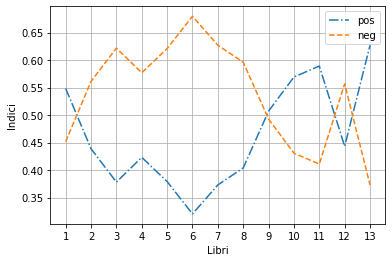

NGRAMS
AUC:  0.8275401069518716


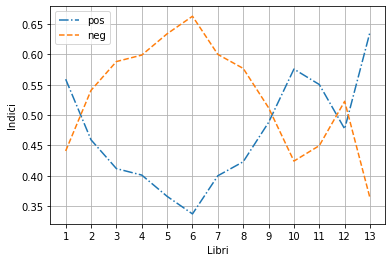

In [182]:
train_algorithm(df, ngrams=False)
train_algorithm(df, ngrams=True)